# Loading stock prices with vnstock

In [2]:
from vnstock import Quote
import pandas as pd

# Define the symbols you want to fetch data for
symbols = ['REE', 'FMC', 'DHC']
print(f"Fetching historical price data for: {symbols}")

# Dictionary to store historical data for each symbol
all_historical_data = {}

# Set date range
start_date = '2024-01-01'
end_date = '2025-03-19'
interval = '1D'

# Fetch historical data for each symbol
for symbol in symbols:
    try:
        print(f"\nProcessing {symbol}...")
        quote = Quote(symbol=symbol)
        
        # Fetch historical price data
        historical_data = quote.history(
            start=start_date,
            end=end_date,
            interval=interval,
            to_df=True
        )
        
        if not historical_data.empty:
            all_historical_data[symbol] = historical_data
            print(f"Successfully fetched {len(historical_data)} records for {symbol}")
        else:
            print(f"No historical data available for {symbol}")
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")

# Export all historical data to a single CSV file
if all_historical_data:
    # Create a combined DataFrame with all data
    combined_data = pd.DataFrame()
    
    for symbol, data in all_historical_data.items():
        if not data.empty:
            # Make a copy of the data and rename columns to include symbol
            temp_df = data.copy()
            # Keep 'time' column as is for merging
            for col in temp_df.columns:
                if col != 'time':
                    temp_df.rename(columns={col: f'{symbol}_{col}'}, inplace=True)
            
            if combined_data.empty:
                combined_data = temp_df
            else:
                combined_data = pd.merge(combined_data, temp_df, on='time', how='outer')
    
    # Sort by time
    if not combined_data.empty:
        combined_data = combined_data.sort_values('time')
        
        # Display sample of combined data
        print("\nSample of combined data:")
        print(combined_data.head(3))
        
        # Export combined data to CSV
        combined_csv_filename = 'all_historical_data.csv'
        combined_data.to_csv(combined_csv_filename, index=False, encoding='utf-8-sig')
        print(f"\nAll historical data exported to {combined_csv_filename}")
    
    # Also create a combined DataFrame for close prices only (for comparison purposes)
    combined_prices = pd.DataFrame()
    
    for symbol, data in all_historical_data.items():
        if not data.empty:
            # Extract time and close price
            temp_df = data[['time', 'close']].copy()
            temp_df.rename(columns={'close': f'{symbol}_close'}, inplace=True)
            
            if combined_prices.empty:
                combined_prices = temp_df
            else:
                combined_prices = pd.merge(combined_prices, temp_df, on='time', how='outer')
    
    # Sort by time
    if not combined_prices.empty:
        combined_prices = combined_prices.sort_values('time')
        
        # Export combined close prices to CSV
        combined_close_csv_filename = 'combined_close_prices.csv'
        combined_prices.to_csv(combined_close_csv_filename, index=False, encoding='utf-8-sig')
        print(f"Combined close price data exported to {combined_close_csv_filename}")
else:
    print("No historical data was fetched for any symbol.")

Phiên bản Vnstock 3.2.4 đã có mặt, vui lòng cập nhật với câu lệnh : `pip install vnstock --upgrade`.
Lịch sử phiên bản: https://vnstocks.com/docs/tai-lieu/lich-su-phien-ban
Phiên bản hiện tại 3.2.2

Fetching historical price data for: ['REE', 'FMC', 'DHC']

Processing REE...
Successfully fetched 300 records for REE

Processing FMC...
Successfully fetched 300 records for FMC

Processing DHC...
Successfully fetched 300 records for DHC

Sample of combined data:
        time  REE_open  REE_high  REE_low  REE_close  REE_volume  FMC_open  \
0 2024-01-02     48.54     49.21    48.20      48.54      779590     42.97   
1 2024-01-03     48.54     48.79    48.20      48.62      376152     43.54   
2 2024-01-04     48.88     49.64    48.54      48.71      899128     43.88   

   FMC_high  FMC_low  FMC_close  FMC_volume  DHC_open  DHC_high  DHC_low  \
0     44.17    42.97      43.78       18200     36.32     36.46    35.94   
1     43.88    43.50      43.69       26222     36.08     36.41    36.08   
2     44.07    43.64      43.83       19700     36.36     37.50    36.32   

   DHC_close  DHC_volume  
0      36.08      118392  
1      36.36      163177  
2      37.08      319156  

All histo

In [3]:
#print(combined_prices.head())
#print(combined_data.head())

In [4]:
# Set the time column as index and ensure it's datetime format
combined_prices_indexed = combined_prices.copy()
combined_prices_indexed['time'] = pd.to_datetime(combined_prices_indexed['time'])
combined_prices_indexed.set_index('time', inplace=True)

# Calculate daily returns for each stock
returns_df = pd.DataFrame(index=combined_prices_indexed.index)
for symbol in symbols:
    column_name = f'{symbol}_close'
    returns_df[symbol] = combined_prices_indexed[column_name].pct_change()

# Drop the first row which will have NaN values due to pct_change()
returns_df = returns_df.dropna()
# Create an equal-weighted portfolio
portfolio_returns = returns_df.mean(axis=1)


# Loading VNINDEX for benchmarking

In [6]:
from vnstock import Vnstock
symbol='VCI'
source='VCI'
stock = Vnstock().stock(symbol=symbol, source=source)
stock.trading.price_board(['VNINDEX'])
vnindex_data=stock.quote.history(start=start_date, end=end_date)
print(vnindex_data.head())

        time   open   high    low  close   volume
0 2024-01-02  32.55  32.55  31.83  32.02  7175876
1 2024-01-03  31.94  32.32  31.64  32.32  3332592
2 2024-01-04  32.40  33.04  32.13  32.13  9110211
3 2024-01-05  32.25  32.32  31.91  32.17  3825239
4 2024-01-08  32.36  32.78  32.28  32.32  4107758


In [7]:
# Process VNINDEX data
vnindex_data['time'] = pd.to_datetime(vnindex_data['time'])
vnindex_data.set_index('time', inplace=True)
vnindex_data.sort_index(inplace=True)
    
# Calculate VNINDEX returns
benchmark_rets = vnindex_data['close'].pct_change().dropna()
    
# Align benchmark returns with portfolio returns (same dates)
benchmark_rets = benchmark_rets.reindex(portfolio_returns.index)
benchmark_rets = benchmark_rets.fillna(method='ffill')  # Forward fill any missing dates

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


In [8]:
print(benchmark_rets.head())

time
2024-01-03    0.009369
2024-01-04   -0.005879
2024-01-05    0.001245
2024-01-08    0.004663
2024-01-09    0.000000
Name: close, dtype: float64


In [9]:
# 1. Make a copy of the combined_prices DataFrame
prices_df = combined_prices.copy()

# 2. Convert the 'time' column to datetime if it's not already
prices_df['time'] = pd.to_datetime(prices_df['time'])

# 3. Set the 'time' column as the index
prices_df.set_index('time', inplace=True)

# 4. Extract only the close price columns and rename them to just the symbol names
close_price_columns = [col for col in prices_df.columns if '_close' in col]
prices_df = prices_df[close_price_columns]
prices_df.columns = [col.replace('_close', '') for col in close_price_columns]

# 5. Make sure there are no NaN values
prices_df = prices_df.dropna()
print(prices_df.head())

              REE    FMC    DHC
time                           
2024-01-02  48.54  43.78  36.08
2024-01-03  48.62  43.69  36.36
2024-01-04  48.71  43.83  37.08
2024-01-05  48.45  43.88  37.98
2024-01-08  47.95  43.88  39.50


In [10]:
risk_free_rate=0.02
risk_aversion=1

In [11]:
from pypfopt.expected_returns import returns_from_prices
log_returns=False
returns = returns_from_prices(prices_df, log_returns=log_returns)
returns.head()

,REE,FMC,DHC
time,,,
2024-01-03,0.001648,-0.002056,0.007761
2024-01-04,0.001851,0.003204,0.019802
2024-01-05,-0.005338,0.001141,0.024272
2024-01-08,-0.010320,0.000000,0.040021
2024-01-09,-0.012304,0.013218,-0.004810


# Portfolio Optimization (Mean-Variance, Min-volatilty, Max Utility)

## Setting up returns and covariance variables

In [14]:
from pypfopt import EfficientFrontier, risk_models, expected_returns, DiscreteAllocation
from pypfopt.exceptions import OptimizationError
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import sample_cov #for covariance matrix, get more methods from risk_models
from pypfopt.efficient_frontier import EfficientFrontier


mu=mean_historical_return(prices_df, log_returns=log_returns ) #Optional: add log_returns=True
"""
For most portfolio optimization purposes, the default simple returns pct_change() are adequate, 
but logarithmic returns can provide more robust results in some cases, 
especially when dealing with volatile assets or longer time horizons.
"""
S=sample_cov(prices_df)

### Optional 

In [16]:
"""
from pypfopt.risk_models import CovarianceShrinkage

# Assume 'prices' is a pandas DataFrame of historical asset prices
S = CovarianceShrinkage(prices_df).ledoit_wolf()
"""

"\nfrom pypfopt.risk_models import CovarianceShrinkage\n\n# Assume 'prices' is a pandas DataFrame of historical asset prices\nS = CovarianceShrinkage(prices_df).ledoit_wolf()\n"

## Create an instance of Efficient Frontier

In [18]:
#Createa an instance 
ef=EfficientFrontier(mu,S,weight_bounds=(0, 1)) # Adding weight_bounds is optional, for clarifying short positions, 0 and 1 means weights will be positive

## Generate the EF with simulated portfolios and 3 optimized portfolios

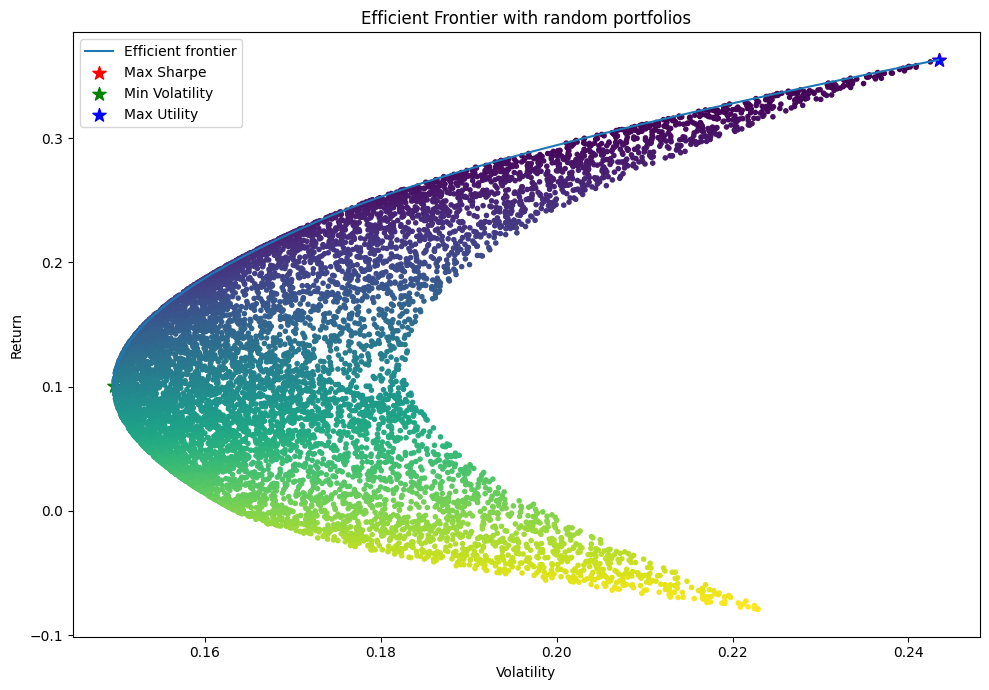

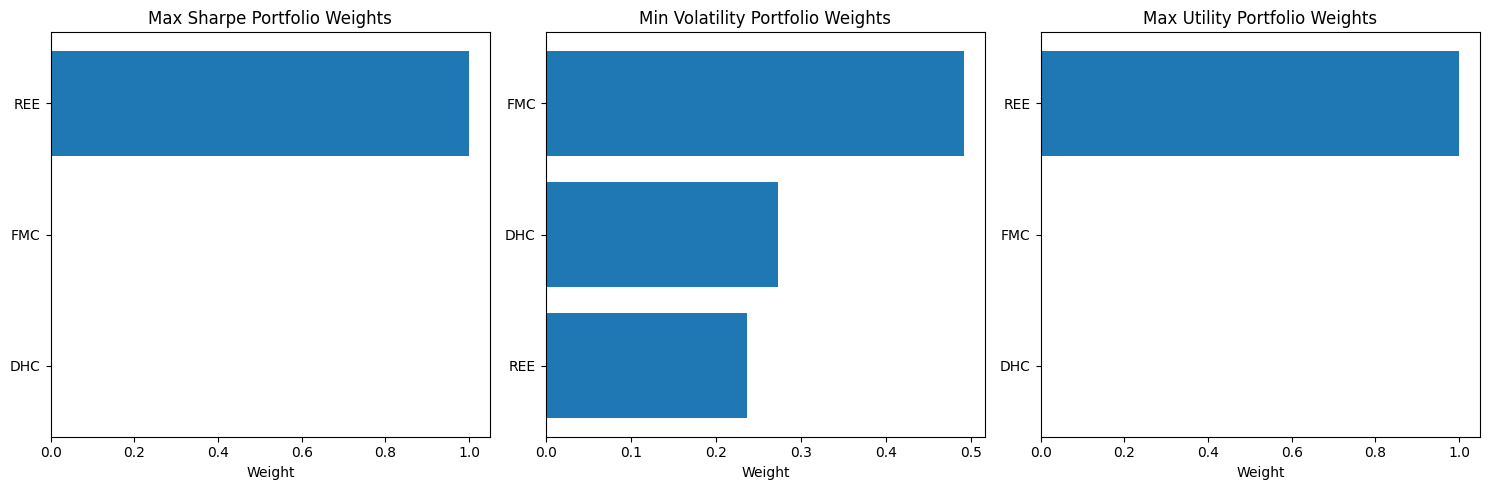

Maximum Sharpe Portfolio:
Expected annual return: 0.3631
Annual volatility: 0.2435
Sharpe Ratio: 1.4093

Minimum Volatility Portfolio:
Expected annual return: 0.1008
Annual volatility: 0.1497
Sharpe Ratio: 0.5397

Maximum Utility Portfolio:
Expected annual return: 0.3631
Annual volatility: 0.2435
Sharpe Ratio: 1.4093
Risk Aversion Parameter: 1


In [20]:
import matplotlib.pyplot as plt
from pypfopt import plotting
import numpy as np
# Create the plot
fig, ax = plt.subplots(figsize=(10, 7))

# Create a new instance for plotting the efficient frontier
ef_plot = EfficientFrontier(mu, S)
plotting.plot_efficient_frontier(ef_plot, ax=ax, show_assets=False)

# Create a separate instance for max Sharpe ratio portfolio
ef_max_sharpe = EfficientFrontier(mu, S)
ef_max_sharpe.max_sharpe(risk_free_rate=risk_free_rate)
weights_max_sharpe = ef_max_sharpe.clean_weights()
ret_tangent, std_tangent, sharpe = ef_max_sharpe.portfolio_performance(risk_free_rate=risk_free_rate)

# Create another separate instance for min volatility portfolio
ef_min_vol = EfficientFrontier(mu, S)
ef_min_vol.min_volatility()
weights_min_vol = ef_min_vol.clean_weights()
ret_min_vol, std_min_vol, sharpe_min_vol = ef_min_vol.portfolio_performance(risk_free_rate=risk_free_rate)

# Create another separate instance for max utility portfolio
ef_max_utility = EfficientFrontier(mu, S)
ef_max_utility.max_quadratic_utility(risk_aversion=risk_aversion, market_neutral=False)
weights_max_utility = ef_max_utility.clean_weights()
ret_utility, std_utility, sharpe_utility = ef_max_utility.portfolio_performance(risk_free_rate=risk_free_rate)

# Plot the tangency portfolio (max Sharpe)
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Plot the minimum volatility portfolio
ax.scatter(std_min_vol, ret_min_vol, marker="*", s=100, c="g", label="Min Volatility")

# Plot the maximum utility portfolio
ax.scatter(std_utility, ret_utility, marker="*", s=100, c="b", label="Max Utility")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(ef_plot.n_assets), n_samples)
rets = w.dot(ef_plot.expected_returns)
stds = np.sqrt(np.diag(w @ ef_plot.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()

# In a separate cell, plot the weights for all three portfolios
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plotting.plot_weights(weights_max_sharpe)
plt.title("Max Sharpe Portfolio Weights")

plt.subplot(1, 3, 2)
plotting.plot_weights(weights_min_vol)
plt.title("Min Volatility Portfolio Weights")

plt.subplot(1, 3, 3)
plotting.plot_weights(weights_max_utility)
plt.title("Max Utility Portfolio Weights")

plt.tight_layout()
plt.show()

# Print the performance metrics for comparison
print("Maximum Sharpe Portfolio:")
print(f"Expected annual return: {ret_tangent:.4f}")
print(f"Annual volatility: {std_tangent:.4f}")
print(f"Sharpe Ratio: {sharpe:.4f}")

print("\nMinimum Volatility Portfolio:")
print(f"Expected annual return: {ret_min_vol:.4f}")
print(f"Annual volatility: {std_min_vol:.4f}")
print(f"Sharpe Ratio: {sharpe_min_vol:.4f}")

print("\nMaximum Utility Portfolio:")
print(f"Expected annual return: {ret_utility:.4f}")
print(f"Annual volatility: {std_utility:.4f}")
print(f"Sharpe Ratio: {sharpe_utility:.4f}")
print(f"Risk Aversion Parameter: {risk_aversion}")

### More examples of optimization methods

In [22]:
"""
#Optimizers, apply the optimizer of choice after instantiating EfficientFrontier(mu,S)
#Portfolio with max sharpe ratio
ef.max_sharpe(risk_free_rate=risk_free_rate)
#ef.min_volatility()
ef.portfolio_performance(risk_free_rate=risk_free_rate)

#Optimizer
#Maximise return for a target risk. The resulting portfolio will have a volatility less than the target (but not guaranteed to be equal).
target_volatility=0.15
conditional_volatility_portfolio=ef.efficient_risk(target_volatility=target_volatility,market_neutral=True)
print(conditional_volatility_portfolio)
#ef.portfolio_performance(risk_free_rate=risk_free_rate) #re-calculate portfolio performance on conditional_volatility_portfolio 

#Optimizer
#Calculate the ‘Markowitz portfolio’, minimising volatility for a given target return.
target_return=0.2
conditional_return_portfolio=ef.efficient_return(target_return=target_return, market_neutral=False) #market_neutral=False means no shorting allowed
print(conditional_return_portfolio)
ef.portfolio_performance(risk_free_rate=risk_free_rate) #re-calculate portfolio performance on conditional_return_portfolio

#Optimizer
#Maximise the given quadratic utility
max_utility_portfolio=ef.max_quadratic_utility(risk_aversion=risk_aversion, market_neutral=False)
print(max_utility_portfolio)
#ef.portfolio_performance(risk_free_rate=risk_free_rate)

"""

'\n#Optimizers, apply the optimizer of choice after instantiating EfficientFrontier(mu,S)\n#Portfolio with max sharpe ratio\nef.max_sharpe(risk_free_rate=risk_free_rate)\n#ef.min_volatility()\nef.portfolio_performance(risk_free_rate=risk_free_rate)\n\n#Optimizer\n#Maximise return for a target risk. The resulting portfolio will have a volatility less than the target (but not guaranteed to be equal).\ntarget_volatility=0.15\nconditional_volatility_portfolio=ef.efficient_risk(target_volatility=target_volatility,market_neutral=True)\nprint(conditional_volatility_portfolio)\n#ef.portfolio_performance(risk_free_rate=risk_free_rate) #re-calculate portfolio performance on conditional_volatility_portfolio \n\n#Optimizer\n#Calculate the ‘Markowitz portfolio’, minimising volatility for a given target return.\ntarget_return=0.2\nconditional_return_portfolio=ef.efficient_return(target_return=target_return, market_neutral=False) #market_neutral=False means no shorting allowed\nprint(conditional_retu

### List stocks by sectors and icb

In [24]:
from vnstock import Listing
sectors=stock.listing.symbols_by_industries()
sectors

,symbol,organ_name,icb_name3,icb_name2,icb_name4,com_type_code,icb_code1,icb_code2,icb_code3,icb_code4
0,TOS,Công ty Cổ phần Dịch vụ biển Tân Cảng,"Thiết bị, Dịch vụ và Phân phối Dầu khí",Dầu khí,Thiết bị và Dịch vụ Dầu khí,CT,0001,0500,0570,0573
1,VTZ,Công ty Cổ phần Sản xuất và Thương mại Nhựa Vi...,Hóa chất,Hóa chất,"Nhựa, cao su & sợi",CT,1000,1300,1350,1353
2,SSH,Công ty Cổ phần Phát triển Sunshine Homes,Bất động sản,Bất động sản,Bất động sản,CT,8000,8600,8630,8633
3,GMH,Công ty Cổ phần Minh Hưng Quảng Trị,Xây dựng và Vật liệu,Xây dựng và Vật liệu,Vật liệu xây dựng & Nội thất,CT,2000,2300,2350,2353
4,BIG,Công ty cổ phần BIG Invest Group,Bất động sản,Bất động sản,"Tư Vấn, Định giá, Môi giới Bất động sản",CT,8000,8600,8630,8637
...,...,...,...,...,...,...,...,...,...,...
1589,XHC,Công ty Cổ phần Xuân Hòa Việt Nam,Hàng gia dụng,Hàng cá nhân & Gia dụng,Thiết bị gia dụng,CT,3000,3700,3720,3726
1590,XMP,Công ty Cổ phần Thủy điện Xuân Minh,Sản xuất & Phân phối Điện,"Điện, nước & xăng dầu khí đốt",Sản xuất & Phân phối Điện,CT,7000,7500,7530,7535
1591,YBC,Công ty Cổ phần Xi măng và Khoáng sản Yên Bái,Xây dựng và Vật liệu,Xây dựng và Vật liệu,Vật liệu xây dựng & Nội thất,CT,2000,2300,2350,2353
1592,YBM,Công ty Cổ phần Khoáng sản Công nghiệp Yên Bái,Khai khoáng,Tài nguyên Cơ bản,Khai khoáng,CT,1000,1700,1770,1775


In [25]:
#Check if a stock in the portfolio is on the list and get relavant information
sectors[sectors['symbol']== 'FMC']

,symbol,organ_name,icb_name3,icb_name2,icb_name4,com_type_code,icb_code1,icb_code2,icb_code3,icb_code4
415,FMC,Công ty Cổ phần Thực phẩm Sao Ta,Sản xuất thực phẩm,Thực phẩm và đồ uống,Nuôi trồng nông & hải sản,CT,3000,3500,3570,3573


In [26]:
#Get a list of unique sectors with icb3
unique_sectors=sectors['icb_name3'].unique() #np array
pd.DataFrame(unique_sectors)

,0
0,"Thiết bị, Dịch vụ và Phân phối Dầu khí"
1,Hóa chất
2,Bất động sản
3,Xây dựng và Vật liệu
4,Sản xuất thực phẩm
5,Du lịch & Giải trí
6,Công nghiệp nặng
7,Nước & Khí đốt
8,Tư vấn & Hỗ trợ Kinh doanh
9,Dược phẩm


# Create a sceener with a pre-defind criteria

In [28]:

from vnstock import Screener
from vnstock import Vnstock
# Initialize Vnstock with a symbol and source
symbol = 'VCI'  # Any valid symbol
source = 'VCI'  # Same as symbol for simplicity
stock = Vnstock().stock(symbol=symbol, source=source)
params = {
            "exchangeName": "HOSE,HNX,UPCOM",
            "marketCap": (100, 1000),
            "dividendYield": (5, 10)
        }

df_filtered = stock.screener.stock(params = params, limit=1700) #drop_lang='vi' 
df_filtered


,ticker,exchange,industry,market_cap,roe,stock_rating,business_operation,business_model,financial_health,alpha,...,profit_last_4q,last_quarter_revenue_growth,second_quarter_revenue_growth,last_quarter_profit_growth,second_quarter_profit_growth,pct_1y_from_peak,pct_away_from_hist_peak,pct_1y_from_bottom,pct_off_hist_bottom,price_vs_sma100
0,ABT,HSX,Thực phẩm và đồ uống,506,21.9,3.4,3.6,3.0,4.8,0.1,...,112.5,34.4,8.2,98.2,208.6,NaN,NaN,NaN,NaN,None
1,ADP,UPCOM,Xây dựng và Vật liệu,719,28.1,3.5,3.4,3.0,5.0,0.1,...,84.8,20.7,13.8,-2.2,-24.2,NaN,NaN,NaN,NaN,None
2,BAX,HNX,Xây dựng và Vật liệu,298,12.5,2.8,2.3,3.5,5.0,0.0,...,26.5,7.6,-16.5,-1.2,-32.6,-18.8,-54.7,8.0,293.0,Giá nằm dưới SMA(100)
3,BSQ,UPCOM,Thực phẩm và đồ uống,873,9.7,2.7,2.0,3.0,3.6,0.1,...,82.4,-16.2,12.2,-66.3,45.4,NaN,NaN,NaN,NaN,None
4,CCI,HSX,"Điện, nước & xăng dầu khí đốt",391,14.4,2.8,1.7,3.5,4.2,0.1,...,36.5,-12.5,-9.2,31.1,-75.9,NaN,NaN,NaN,NaN,None
5,COM,HSX,Bán lẻ,438,5.8,2.6,1.3,3.0,4.2,0.1,...,25.7,-16.6,-16.2,-31.2,-40.5,-9.5,-53.1,29.4,217.4,Giá nằm trên SMA(100)
6,DRL,HSX,"Điện, nước & xăng dầu khí đốt",535,36.7,2.8,3.1,3.6,4.2,0.0,...,46.3,16.5,-0.2,14.5,-10.4,-9.0,-9.8,4.0,1066.2,Giá nằm dưới SMA(100)
7,DSN,HSX,Du lịch và Giải trí,550,29.4,2.9,3.1,3.5,4.2,-0.1,...,85.0,-25.4,-32.9,-47.1,-37.2,-16.7,-15.9,1.2,1190.8,Giá nằm dưới SMA(100)
8,EBS,HNX,Truyền thông,109,11.8,NaN,2.2,NaN,5.0,0.1,...,16.3,42.8,15.3,51.9,38.6,-21.6,-21.6,11.0,614.1,Giá nằm dưới SMA(100)
9,EIC,UPCOM,Xây dựng và Vật liệu,818,12.3,2.8,3.0,3.1,4.2,0.1,...,50.4,800.5,-5.8,-72.4,-117.8,-7.0,-7.0,24.1,468.5,Giá nằm dưới SMA(100)


In [29]:
#screener_df = stock.screener.stock(params={"exchangeName": "HOSE,HNX,UPCOM"}, limit=1700)
#screener_df

# Hierarchical Risk Parity

In [31]:
from pypfopt import HRPOpt
hrp = HRPOpt(returns=returns) #create the object
weights = hrp.optimize() #optimize the object
weights

OrderedDict([('DHC', np.float64(0.280008567778799)),
             ('FMC', np.float64(0.4150523222546779)),
             ('REE', np.float64(0.30493910996652307))])

### Round the weights and save to a json file for webview

In [33]:
hrp.clean_weights()
#Saving weights to csv
hrp.save_weights_to_file("./outputs/hrp_weights.json")


# Dollars Allocation

In [35]:
# This extracts the last row of prices_df and converts it to a Series

from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
latest_prices = get_latest_prices(prices_df) #Alternatives: latest_prices = prices_df.iloc[-1]
# Assuming you already have optimized weights (e.g., from max_sharpe or min_volatility)
# And a total portfolio value
portfolio_value = 100000  # 1 million VND

# You can use either the Series or dict version of latest_prices
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=portfolio_value)
allocation, leftover = da.greedy_portfolio()

### Plotting with the HRP portfolio with pypfopt

<Axes: >

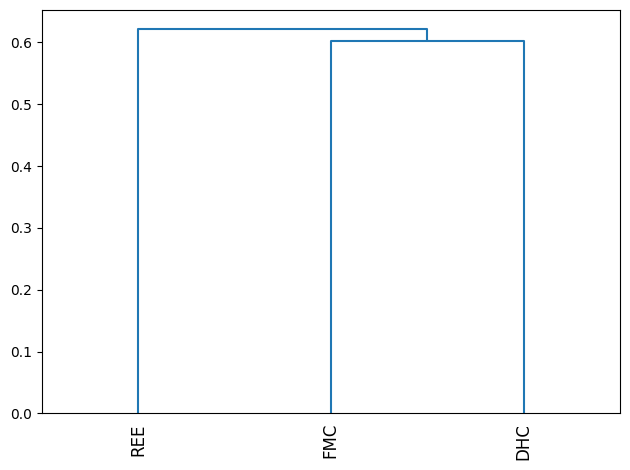

In [37]:
from pypfopt import plotting
plotting.plot_dendrogram(hrp, ax=None, show_tickers=True)

### Plot the covariance

<Axes: >

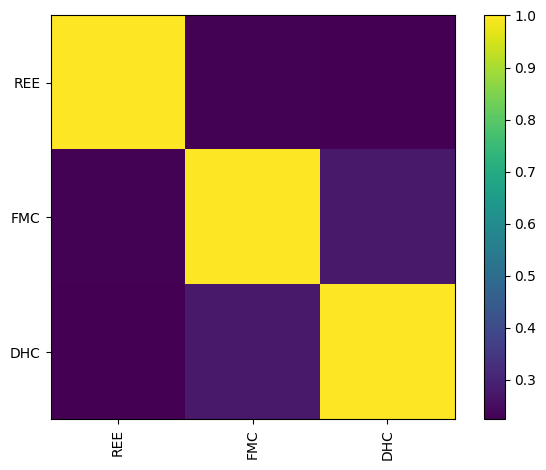

In [39]:
# Plot the covariance
plotting.plot_covariance(S, plot_correlation=True, show_tickers=True)

# Riskfolio

In [41]:
import warnings
#warnings.filterwarnings("ignore")
import riskfolio as rp
"""
# Building the portfolio object
port = rp.Portfolio(returns=returns)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov)
"""
# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

#w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
#display(w.T)



### Plot the weights on a pie chart

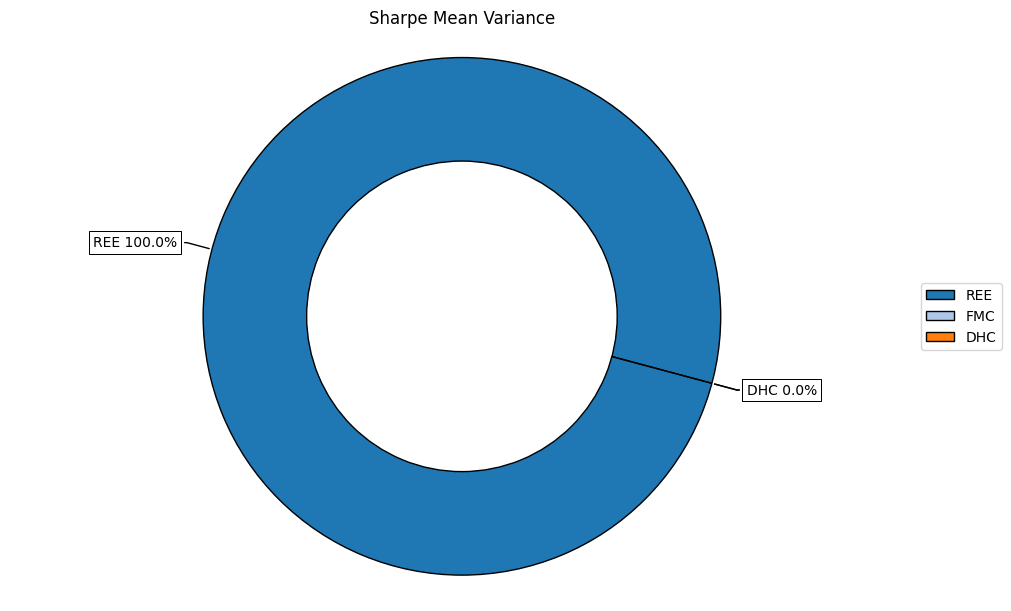

In [43]:
# Plotting the composition of the portfolio
#Convert weights_max_sharpe variable to series or use w=w to use the wieghts generated by riskfolio

ax = rp.plot_pie(w=pd.Series(weights_max_sharpe), title='Sharpe Mean Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

### Setting up risk measures variables

In [45]:
# Risk Measures available:
#
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded cumulative returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.

rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM', 'CVaR',
       'EVaR', 'WR', 'MDD', 'ADD', 'CDaR', 'UCI', 'EDaR']
"""
w_s = pd.DataFrame([])

for i in rms:
    w = port.optimization(model=model, rm=i, obj=obj, rf=rf, l=l, hist=hist)
    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = rms
"""

'\nw_s = pd.DataFrame([])\n\nfor i in rms:\n    w = port.optimization(model=model, rm=i, obj=obj, rf=rf, l=l, hist=hist)\n    w_s = pd.concat([w_s, w], axis=1)\n    \nw_s.columns = rms\n'

In [46]:
#w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

NameError: name 'w_s' is not defined

### Plot the historical compounded cummulative returns

In [ ]:
ax = rp.plot_series(returns=returns,
                    w=pd.Series(weights_max_sharpe),
                    cmap='tab20',
                    height=6,
                    width=10,
                    ax=None)

### Plot risk contribution on a bar chart

In [ ]:
ax = rp.plot_risk_con(w=weights_max_sharpe,
                      cov=S, #using covariance from pypfopt lib, which in this case is sample_cov
                      returns=returns,
                      rm=rm,
                      rf=risk_free_rate,
                      alpha=0.05,
                      color="tab:blue",
                      height=6,
                      width=10,
                      t_factor=252,
                      ax=None)

### Plot a histogram of returns distribution

In [ ]:
ax = rp.plot_hist(returns=returns,
                  w=pd.Series(weights_max_sharpe),
                  alpha=0.05,
                  bins=50,
                  height=6,
                  width=10,
                  ax=None)

In [ ]:
ax = rp.plot_range(returns=returns,
                   w=pd.Series(weights_max_sharpe),
                   alpha=0.05,
                   a_sim=100,
                   beta=None,
                   b_sim=None,
                   bins=50,
                   height=6,
                   width=10,
                   ax=None)

In [ ]:
"""
ax = rp.jupyter_report(returns,
                       w,
                       rm='MV',
                       rf=0,
                       alpha=0.05,
                       height=6,
                       width=14,
                       others=0.05,
                       nrow=25)
"""                       

### Plot the full report

In [ ]:
ax = rp.plot_table(returns=returns,
                   w=pd.Series(weights_max_sharpe),
                   MAR=0,
                   alpha=0.05,
                   ax=None)

### Save a report to excel

In [ ]:
rp.excel_report(returns,
                w,
                rf=risk_free-rate, # could =0 or =risk_free-rate
                alpha=0.05,
                t_factor=252,
                ini_days=1,
                days_per_year=252,
                name="./outputs/report")

In [ ]:
ax = rp.plot_factor_risk_con(w=pd.Series(weights_max_sharpe),
                             cov=S,
                             returns=returns,
                             factors=returns,
                             B=None,
                             const=True,
                             rm=rm,
                             rf=0,
                             feature_selection="PCR", #Indicate the method used to estimate the loadings matrix, PCR or stepwise
                             n_components=0.95,
                             height=6,
                             width=10,
                             t_factor=252,
                             ax=None)

In [ ]:
ax = rp.plot_drawdown(returns=returns,
                      w=pd.Series(weights_max_sharpe), # or w=w
                      alpha=0.05,
                      height=8,
                      width=10,
                      ax=None)

# Quantstats

In [ ]:
import quantstats as qs
qs.extend_pandas()

In [ ]:
#View a complete list of available metrics
[f for f in dir(qs.stats) if f[0] != '_'] 

In [ ]:
qs.stats.avg_loss(portfolio_returns)

In [ ]:
#View a complete list of available plots, some will not work in pandas 3.0 
[f for f in dir(qs.plots) if f[0] != '_']

In [ ]:
qs.plots.rolling_beta(portfolio_returns,benchmark_rets) #benchmark_rets should have been index fund rather than VNINDEX

# Constraints Portfolio

In [ ]:
import pandas as pd

# Function to create a sector mapping dictionary from the grouped sectors
def create_sector_mapper(grouped_data):
    sector_mapper = {}
    
    for sector_name, group_df in grouped_data:
        # For each stock in this sector group, add to the dictionary
        for _, row in group_df.iterrows():
            sector_mapper[row['symbol']] = sector_name
    
    return sector_mapper

# Group by sector
grouped = sectors.groupby('icb_name3')

# Create the sector mapper dictionary
sector_mapper = create_sector_mapper(grouped)

print(f"Created sector mapper for {len(sector_mapper)} symbols")

In [ ]:
#sector_mapper

In [ ]:
sector_lower = {"Sản xuất & Phân phối Điện": 0.1, "Sản xuất thực phẩm": 0.05}  # Min percentages
sector_upper = {"Sản xuất & Phân phối Điện": 0.4, "Sản xuất thực phẩm/Gas": 0.2}      # Max percentages

In [ ]:
import json
import os
output_dir = "./outputs"
# Save the sector mapper to a JSON file in the specified directory
output_path = os.path.join(output_dir, "sector_map.json")
with open(output_path, 'w',encoding='utf-8') as json_file:
    json.dump(sector_mapper, json_file, indent=4, ensure_ascii=False) #ensure_ascii=False and encoding='utf-8' for Vietnamese language encoding

In [ ]:
from pypfopt import EfficientFrontier
#Instantiate an instance  
constraint_portfolio = EfficientFrontier(mu, S)

# Apply sector constraints
constraint_portfolio.add_sector_constraints(sector_mapper, sector_lower, sector_upper)




In [ ]:
# Optimize the portfolio
constraint_portfolio_weights = constraint_portfolio.max_sharpe(risk_free_rate=risk_free_rate)
constraint_portfolio_weights

In [ ]:
import os
# Convert the dictionary to a DataFrame for CSV export
sector_df = pd.DataFrame(list(sector_mapper.items()), columns=['symbol', 'sector'])

# Ensure the output directory exists
output_dir = "./outputs"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the DataFrame to a CSV file with UTF-8 encoding
output_path = os.path.join(output_dir, "sector_map.csv")
sector_df.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"Sector mapper saved to '{output_path}' with UTF-8 encoding")

# Tradingview

In [ ]:

#!pip install --upgrade --no-cache-dir git+https://github.com/rongardF/tvdatafeed.git
#https://github.com/rongardF/tvdatafeed?tab=readme-ov-file

from tvDatafeed import TvDatafeed, Interval
import tvDatafeed
import datetime
#Getting stock data using nologin method
tv = TvDatafeed()

data = tv.get_hist('REE','HOSE', Interval.in_monthly,n_bars=120)


In [ ]:
#data

In [79]:
"""
from tvDatafeed import TvDatafeed,Interval

username = 'YourTradingViewUsername'
password = 'YourTradingViewPassword'
    
tv=TvDatafeed(username, password, chromedriver_path=None)

"""

"\nfrom tvDatafeed import TvDatafeed,Interval\n\nusername = 'YourTradingViewUsername'\npassword = 'YourTradingViewPassword'\n    \ntv=TvDatafeed(username, password, chromedriver_path=None)\n\n"

# Visualization with vnstock_ezchart 

In [1]:
from vnstock_ezchart import *
from vnstock import Vnstock
ezchart = MPlot() # Khởi tạo đối tượng
# Set date range
start_date = '2024-01-01'
end_date = '2025-03-19'
interval = '1D'
stock = Vnstock().stock(symbol='REE', source='VCI')
candle_df = stock.quote.history(start= start_date, end= end_date)

Phiên bản Vnstock 3.2.4 đã có mặt, vui lòng cập nhật với câu lệnh : `pip install vnstock --upgrade`.
Lịch sử phiên bản: https://vnstocks.com/docs/tai-lieu/lich-su-phien-ban
Phiên bản hiện tại 3.2.2

In [2]:
"""
ezchart.combo_chart(candle_df['volume'] / 1000_000, candle_df['close']/1000,
                  left_ylabel='Volume (M)', right_ylabel='Price (K)',
                  color_palette='vnstock', palette_shuffle=True,
                  show_legend=False,
                  figsize=(10, 6),
                  title='Khối lượng giao dịch và giá đóng cửa theo thời gian',
                  title_fontsize=14
                  )
"""

"\nezchart.combo_chart(candle_df['volume'] / 1000_000, candle_df['close']/1000,\n                  left_ylabel='Volume (M)', right_ylabel='Price (K)',\n                  color_palette='vnstock', palette_shuffle=True,\n                  show_legend=False,\n                  figsize=(10, 6),\n                  title='Khối lượng giao dịch và giá đóng cửa theo thời gian',\n                  title_fontsize=14\n                  )\n"

In [3]:
CashFlow = stock.finance.cash_flow(period='year', dropna=True)

In [4]:
# List the columns headers 
CashFlow.columns.tolist()

['ticker',
 'yearReport',
 'Net Profit/Loss before tax',
 'Depreciation and Amortisation',
 'Provision for credit losses',
 'Unrealized foreign exchange gain/loss',
 'Profit/Loss from investing activities',
 'Interest Expense',
 'Operating profit before changes in working capital',
 'Increase/Decrease in receivables',
 'Increase/Decrease in inventories',
 'Increase/Decrease in payables',
 'Increase/Decrease in prepaid expenses',
 'Interest paid',
 'Business Income Tax paid',
 'Other receipts from operating activities',
 'Other payments on operating activities',
 'Net cash inflows/outflows from operating activities',
 'Purchase of fixed assets',
 'Proceeds from disposal of fixed assets',
 'Loans granted, purchases of debt instruments (Bn. VND)',
 'Collection of loans, proceeds from sales of debts instruments (Bn. VND)',
 'Investment in other entities',
 'Proceeds from divestment in other entities',
 'Gain on Dividend',
 'Net Cash Flows from Investing Activities',
 'Increase in charter c

## Transpose the CF dataframe 

In [30]:
#CashFlow
CashFlow_transposed = CashFlow.T
CashFlow_transposed.columns = CashFlow['yearReport']
# Drop the duplicate 'yearReport' row
CashFlow_transposed = CashFlow_transposed.drop('yearReport')
CashFlow_transposed

In [5]:
"""

ezchart.bar(CashFlow['Net cash inflows/outflows from operating activities'] / 1000_000_000, 
          color_palette='vnstock', palette_shuffle=False, 
          title='Biểu đồ cột', xlabel='Danh mục', ylabel='Giá trị', 
          grid=False, 
          data_labels=True,
          show_legend=False,
          legend_title='Chú thích',
          series_names=['Test'],
          figsize=(10, 6), 
          rot=45, 
          width=0.7,
          title_fontsize=15,
          label_fontsize=10,
          bar_edge_color='lightgrey'
          )
"""

"\nezchart.bar(CashFlow['Net cash inflows/outflows from operating activities'] / 1000_000_000, \n          color_palette='vnstock', palette_shuffle=False, \n          title='Biểu đồ cột', xlabel='Danh mục', ylabel='Giá trị', \n          grid=False, \n          data_labels=True,\n          show_legend=False,\n          legend_title='Chú thích',\n          series_names=['Test'],\n          figsize=(10, 6), \n          rot=45, \n          width=0.7,\n          title_fontsize=15,\n          label_fontsize=10,\n          bar_edge_color='lightgrey'\n          )\n"

# Port the built-in visulization method to seaborn for a more polished look

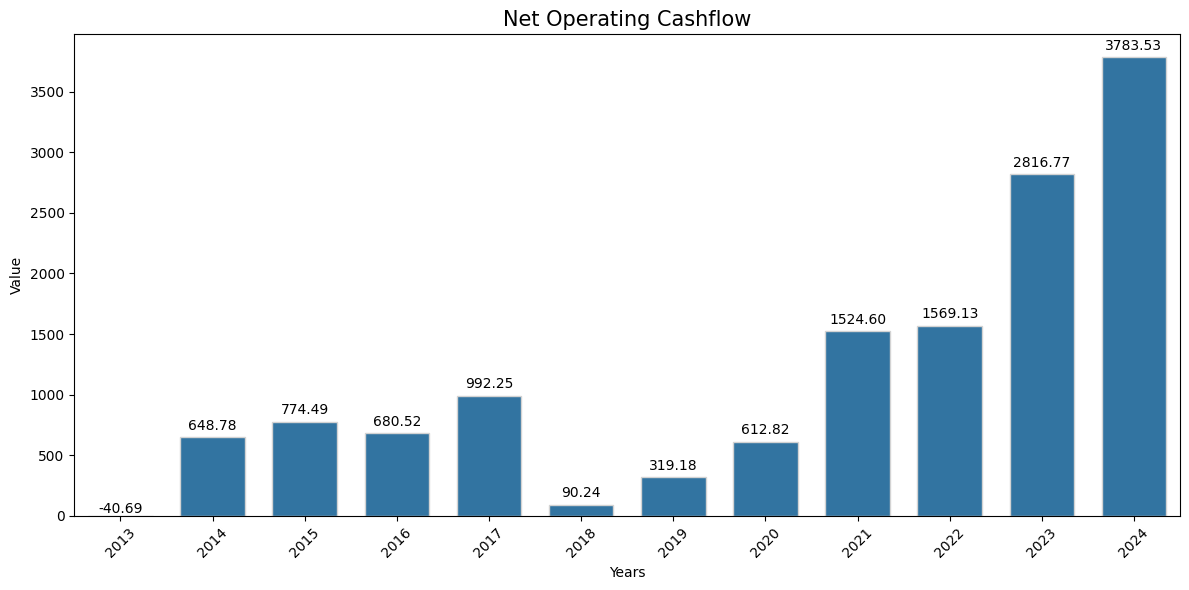

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming CashFlow is a DataFrame you already have
# Normalize values to billions
data = CashFlow['Net cash inflows/outflows from operating activities'] / 1000_000_000

# Create figure with specified size
plt.figure(figsize=(12, 6))

# Sort data by year to ensure proper ordering
sorted_indices = CashFlow['yearReport'].argsort()
years = CashFlow['yearReport'].iloc[sorted_indices]
sorted_data = data.iloc[sorted_indices]

# Create the vertical bar plot with sorted data
ax = sns.barplot(
    x=years,                # Sorted years on x-axis
    y=sorted_data,          # Sorted data values on y-axis
    edgecolor='lightgrey',
    width=0.7
)

# Set title and labels with specified font sizes
plt.title('Net Operating Cashflow', fontsize=15)
plt.xlabel('Years', fontsize=10)
plt.ylabel('Value', fontsize=10)

# Turn off grid
plt.grid(False)

# Add data labels with minimal gap above bars
for i, v in enumerate(sorted_data):
    # Much smaller offset - adjust the multiplier as needed
    offset = 0.01 * max(sorted_data)
    
    ax.text(
        i,                       # x position (bar index)
        v + offset,              # Position with minimal gap
        f'{v:.2f}',              # formatted value 
        ha='center',             # horizontal alignment
        va='bottom',             # vertical alignment
        fontsize=10
    )

# Adjust y-axis limit to make room for labels
ymax = max(sorted_data) * 1.05  # Add just 5% padding to y-axis
plt.ylim(0, ymax)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()

# Save the seaborn figure
plt.savefig('./outputs/Net OCF.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

In [82]:
"""
# For plotly, Add this at the end instead of fig.show()
fig.write_html("./outputs/cash_flow_chart.html")  # Saves as interactive HTML
# Or
fig.write_image("./outputs/cash_flow_chart.png")  # Requires kaleido package
"""



<Figure size 640x480 with 0 Axes>